In [1]:
import os, sys
import pandas as pd
import shutil
import subprocess
import numpy as np
import json
import glob

## Notebook for multiple chains

## Inputs

In [2]:
# only chains for MSA
input="full_scgd_tcr"
input_pdb="/home/tsatler/RFdif/ClusterProteinDesign/scripts/msa_mpnn_af2/input/full_scgd_tcr/full_tcr_igonly.pdb"

# select parts that you want predicted
full_pdb="/home/tsatler/RFdif/ClusterProteinDesign/scripts/msa_mpnn_af2/input/full_scgd_tcr/full_tcr.pdb"
full_chains="D,G" # chains to design

# fix positions - 12,15,16,17,19,21,66,69,84 (chainG)
#fix_positions=np.array([144,147,148,149,151,153,198,201,216,217]) # Positions to fix (numbering should be the same as with input sequence)

fixed_positions = {
    "D": np.array([]),
    "G": np.array([12,15,16,17,19,21,66,69,84])
}

conservation=[0.5, 0.7] # Fraction of conserved residues to fix

# prepare out dir
os.makedirs(f"input/{input}", exist_ok=True)
os.makedirs(f"output/{input}", exist_ok=True)

## Functions

In [3]:
sys.path.append('helper_scripts/')
from mmseq_api import run_mmseq2_msa_rosettafold, generate_fasta_sequence_from_pdb, parse_fasta
from parse_msa import get_conserved_positions, process_a3m_file_rf2, parse_a3m, process_a3m_file_af2
from parse_mpnn_seqs import extract_scores, calculate_seq_identity
from plot_scores import create_and_save_plot

## get input sequence

In [69]:
# Parse PDB
seqs = generate_fasta_sequence_from_pdb(input_pdb,f"input/{input}/")
for chain_name, sequence in seqs.items():
    print(f"Chain {chain_name}: {len(sequence)}")
seqs

Chain D: 205
Chain G: 230


{'D': 'IELVPEHQTVPVSIGVPATLRCSMKGEAIGNYYINWYRKTQGNTMTFIYREKDIYGPGFKDNFQGDIDIAKNLAVLKILAPSERDEGSYYCASDTLGMGGEYTDKLIFGKGTRVTVEPRSQPHTKPSVFVMKNGTNVACLVKEFYPKDIRINLVSSKKITEFDPAIVISPSGKYNAVKLGKYEDSNSVTCSVQHDNKTVHSTDFE',
 'G': 'GHLEQPQISSTKTLSKTARLECVVSGITISATSVYWYRERPGEVIQFLVSISYDGTVRKESGIPSGKFEVDRIPETSTSTLTIHNVEKQDIATYYCALWEAQQELGKKIKVFGPGTKLIITDKQLDADVSPKPTIFLPSIAETKLQKAGTYLCLLEKFFPDVIKIHWQEKKSNTILGSQEGNTMKTNDTYMKFSWLTVPEESLDKEHRCIVRHENNKNGVDQEIIFPPIK'}

In [70]:
# Input sequence
input_sequence = ":".join(seqs.values())
input_sequence

'IELVPEHQTVPVSIGVPATLRCSMKGEAIGNYYINWYRKTQGNTMTFIYREKDIYGPGFKDNFQGDIDIAKNLAVLKILAPSERDEGSYYCASDTLGMGGEYTDKLIFGKGTRVTVEPRSQPHTKPSVFVMKNGTNVACLVKEFYPKDIRINLVSSKKITEFDPAIVISPSGKYNAVKLGKYEDSNSVTCSVQHDNKTVHSTDFE:GHLEQPQISSTKTLSKTARLECVVSGITISATSVYWYRERPGEVIQFLVSISYDGTVRKESGIPSGKFEVDRIPETSTSTLTIHNVEKQDIATYYCALWEAQQELGKKIKVFGPGTKLIITDKQLDADVSPKPTIFLPSIAETKLQKAGTYLCLLEKFFPDVIKIHWQEKKSNTILGSQEGNTMKTNDTYMKFSWLTVPEESLDKEHRCIVRHENNKNGVDQEIIFPPIK'

## MSA generation

In [74]:
msa_paths = {}

#print("Running paired MSA for AF2!")
#run_mmseq2_msa_rosettafold(input_sequence,f"output/{input}",cov=50, id=90, max_msa=2048,mode="unpaired_paired", msa_name=f"{input}_paired")
#msa_paths["paired"] = f"output/{input}/{input}_paired.a3m"

print("Running unpaired MSA for calculation of conserved residues!")
for chain_name, sequence in seqs.items():
    msa_path = f"output/{input}/{input}_chain{chain_name}.a3m"
    msa_paths[chain_name] = msa_path
    print(f"Making MSA for chain {chain_name}. Will be stored at: {msa_path}")
    run_mmseq2_msa_rosettafold(sequence,f"output/{input}",cov=50, id=90, max_msa=2048,mode="unpaired_paired", msa_name=f"{input}_chain{chain_name}")

print(msa_paths)

Running paired MSA for AF2!
Starting MSA...
getting paired MSA
getting unpaired MSA


- 17:39:26.136 INFO: Input file = output/full_scgd_tcr/full_scgd_tcr_paired/paired_in_full_scgd_tcr_paired.a3m

- 17:39:26.136 INFO: Output file = output/full_scgd_tcr/full_scgd_tcr_paired/paired_out_full_scgd_tcr_paired.a3m

- 17:39:26.192 INFO: Input file = output/full_scgd_tcr/full_scgd_tcr_paired/in_full_scgd_tcr_paired_0.a3m

- 17:39:26.192 INFO: Output file = output/full_scgd_tcr/full_scgd_tcr_paired/out_full_scgd_tcr_paired_0.a3m

- 17:39:26.299 INFO: Input file = output/full_scgd_tcr/full_scgd_tcr_paired/in_full_scgd_tcr_paired_1.a3m

- 17:39:26.299 INFO: Output file = output/full_scgd_tcr/full_scgd_tcr_paired/out_full_scgd_tcr_paired_1.a3m



Done!
Running unpaired MSA for calculation of conserved residues!
Making MSA for chain D. Will be stored at: output/full_scgd_tcr/full_scgd_tcr_chainD.a3m
Starting MSA...
getting unpaired MSA
Done!
Making MSA for chain G. Will be stored at: output/full_scgd_tcr/full_scgd_tcr_chainG.a3m
Starting MSA...
getting unpaired MSA


- 17:39:26.409 INFO: Input file = output/full_scgd_tcr/full_scgd_tcr_chainD/in_full_scgd_tcr_chainD_0.a3m

- 17:39:26.409 INFO: Output file = output/full_scgd_tcr/full_scgd_tcr_chainD/out_full_scgd_tcr_chainD_0.a3m

- 17:39:26.541 INFO: Input file = output/full_scgd_tcr/full_scgd_tcr_chainG/in_full_scgd_tcr_chainG_0.a3m

- 17:39:26.541 INFO: Output file = output/full_scgd_tcr/full_scgd_tcr_chainG/out_full_scgd_tcr_chainG_0.a3m



Done!
{'paired': 'output/full_scgd_tcr/full_scgd_tcr_paired.a3m', 'D': 'output/full_scgd_tcr/full_scgd_tcr_chainD.a3m', 'G': 'output/full_scgd_tcr/full_scgd_tcr_chainG.a3m'}


## Get conserved residues

In [8]:
import numpy as np

chains_dict = {}
conserved_positions_dict = {}
fixed_positions_dict = {}

for chain_name, sequence in seqs.items():
    msa = f"output/{input}/{input}_chain{chain_name}.a3m"
    
    # Initialize dictionaries for the current chain
    conserved_positions_dict[chain_name] = {}
    fixed_positions_dict[chain_name] = {}

    for conv_frac in conservation:
        conserved_positions = get_conserved_positions(msa, frac_conserved=conv_frac, min_count=10)
        conserved_positions_dict[chain_name][conv_frac] = conserved_positions
        
        # Calculate fix_conserved positions by combining conserved and fixed positions
        fix_conserved_positions = list(np.unique(np.hstack((conserved_positions, fixed_positions.get(chain_name, [])))))
        fixed_positions_dict[chain_name][conv_frac] = fix_conserved_positions


In [9]:
for chain_name, cons_dict in conserved_positions_dict.items():
    for conv_frac, cons_positions in cons_dict.items():
        print(f"Chain: {chain_name}, Conservation: {conv_frac}, Conserved: {len(cons_positions)}, Fixed: {len(fixed_positions_dict[chain_name][conv_frac])} of total {len(seqs[chain_name])}")


Chain: D, Conservation: 0.5, Conserved: 102, Fixed: 102 of total 205
Chain: D, Conservation: 0.7, Conserved: 143, Fixed: 143 of total 205
Chain: G, Conservation: 0.5, Conserved: 115, Fixed: 121 of total 230
Chain: G, Conservation: 0.7, Conserved: 161, Fixed: 163 of total 230


In [10]:
# Custom JSON encoder to handle int64 data type
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        return super(NumpyEncoder, self).default(obj)

# Create a dictionary to store all the data
data = {
    "input": input,
    "input_pdb": input_pdb,
    "full_pdb": full_pdb,
    "full_chains": full_chains,
    "input_sequence": input_sequence,
    "chain_seqs": seqs,
    "msa_paths": msa_paths,
    "fixed_positions": {k: v.tolist() for k, v in fixed_positions.items()},
    "conserved_positions_dict": {k: {k2: v2.tolist() if isinstance(v2, np.ndarray) else v2 for k2, v2 in v.items()} for k, v in conserved_positions_dict.items()},
    "fixed_positions_dict": {k: {k2: v2.tolist() if isinstance(v2, np.ndarray) else v2 for k2, v2 in v.items()} for k, v in fixed_positions_dict.items()}
}

# Define the filename for the JSON file
json_file_path = f'output/{input}/input_data.json'

# Save all the data to a single JSON file using the custom encoder
with open(json_file_path, "w") as json_file:
    json.dump(data, json_file, indent=3, cls=NumpyEncoder)

In [12]:
# Chimera
print("select in chimera:")
for chain_name, frac in fixed_positions_dict.items():
    for conv_frac, positions in frac.items():
        int_positions = [int(position) for position in positions]
        pos = ",".join(map(str, int_positions))
        print(f"select #3/{chain_name}:{pos}")

select in chimera:
select #3/D:1,2,3,4,5,6,7,9,10,11,12,14,15,17,20,21,22,23,25,26,29,32,33,36,37,38,39,41,42,43,45,46,47,50,55,57,58,62,63,64,65,66,68,70,72,74,75,76,78,79,81,83,84,85,86,87,89,90,91,92,107,108,109,111,112,114,115,116,118,126,127,128,129,137,139,140,141,143,144,145,146,149,151,153,157,170,172,174,175,176,178,188,189,190,192,194,198,201,202,203,204,205
select #3/D:1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,25,26,28,29,30,32,33,34,35,36,37,38,39,41,42,43,44,45,46,47,48,49,50,53,55,57,58,59,60,62,63,64,65,66,68,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,100,107,108,109,111,112,114,115,116,118,120,126,127,128,129,130,131,133,135,136,137,138,139,140,141,142,143,144,145,146,147,149,150,151,153,156,157,167,168,170,172,174,175,176,178,180,182,184,187,188,189,190,192,194,196,197,198,199,201,202,203,204,205
select #3/G:1,2,3,4,5,7,9,11,12,15,16,17,18,19,20,21,22,25,26,34,35,36,37,38,39,40,41,42,44,45,49,50,53,61,62,64,66,67,68,69,71,72,75,

## Prepare for MPNN

In [42]:
### ProteinMPNN setup
proteinmpnn_dir = '/home/tsatler/ProteinMPNN'
parse_multiple_chains_script = f'{proteinmpnn_dir}/helper_scripts/parse_multiple_chains.py'
assign_fixed_chains_script = f'{proteinmpnn_dir}/helper_scripts/assign_fixed_chains.py'
make_fixed_position_script = f'{proteinmpnn_dir}/helper_scripts/make_fixed_positions_dict.py'
make_tied_position_script = f'{proteinmpnn_dir}/helper_scripts/make_tied_positions_dict.py'


### mpnn parameters
mpnn_temp=[0.1, 0.2, 0.3]
soluble_weights=True
number_of_seq=300

# copy pdb to separate folder
mpnn_pdb=f"input/{input}/mpnn_pdb/"
os.makedirs(mpnn_pdb, exist_ok=True)
if full_pdb:
    shutil.copy2(full_pdb,mpnn_pdb)
else:
    shutil.copy2(input_pdb,mpnn_pdb)

# chains to design
chains_to_design=""
chains_to_design=" ".join(seqs.keys())
print(f"designing chains: {chains_to_design}")

# use soluble weights
soluble_weights_flag=""
if soluble_weights:
    soluble_weights_flag=" --use_soluble_model"

# temps
temps=" ".join(map(str, mpnn_temp))

designing chains: D G


In [50]:
### Prepare MPNN script
mpnn_outdir=f"output/{input}/mpnn_out"
os.makedirs(mpnn_outdir, exist_ok=True)

for conv in conservation:
    fixed_pos_list=[]
    for chain in fixed_positions_dict:
        #print(" ".join(map(str, map(int, fixed_positions_dict[chain][conv]))))
        fixed_pos_list.append(" ".join(map(str, map(int, fixed_positions_dict[chain][conv]))))

    fixed_positions=','.join(fixed_pos_list)
    print(f"fixed_positions for {conv} are:{fixed_positions}")

    #fixed_positions=' '.join([str(i) for i in positions])
    conv_perc=int(conv*100)
    seq_out=f"{mpnn_outdir}/mpnn_conv{conv_perc}"
    os.makedirs(seq_out, exist_ok=True)

    mpnn_txt = \
f'''#!/bin/bash
#SBATCH -J scFvCD19-mpnn
#SBATCH -p gpu
#SBATCH --gres=gpu:A40:1
#SBATCH --output={mpnn_outdir}/mpnn_conv{conv_perc}.out

source /home/tsatler/anaconda3/etc/profile.d/conda.sh
conda activate mlfold

folder_with_pdbs='{mpnn_pdb}'
path_for_parsed_chains='{seq_out}/parsed_pdbs.jsonl'
path_for_assigned_chains='{seq_out}/assigned_pdbs.jsonl'
path_for_fixed_positions='{seq_out}/fixed_pdbs.jsonl'
path_for_tied_positions='{seq_out}/tied_pdbs.jsonl'
chains_to_design="{chains_to_design}"
path_for_designed_sequences='{seq_out}' 

python {parse_multiple_chains_script} --input_path=$folder_with_pdbs --output_path=$path_for_parsed_chains
python {assign_fixed_chains_script} --input_path=$path_for_parsed_chains --output_path=$path_for_assigned_chains --chain_list "$chains_to_design"
python {make_fixed_position_script} --input_path=$path_for_parsed_chains --position_list "{fixed_positions}" --chain_list "$chains_to_design" --output_path=$path_for_fixed_positions
#python {make_tied_position_script} --input_path=$path_for_parsed_chains --output_path=$path_for_tied_positions --homooligomer 1

python {proteinmpnn_dir}/protein_mpnn_run.py \
    --jsonl_path $path_for_parsed_chains \
    --chain_id_jsonl $path_for_assigned_chains \
    --fixed_positions_jsonl $path_for_fixed_positions \
    --tied_positions_jsonl $path_for_tied_positions \
    --out_folder $path_for_designed_sequences \
    --num_seq_per_target {number_of_seq} \
    --sampling_temp "{temps}" \
    --batch_size 8 \
    --omit_AAs='XC' {soluble_weights_flag}
    '''
    script=f"{mpnn_outdir}/run_mpnn_{conv_perc}.sh"

    with open(script,'w') as f:
        f.write(mpnn_txt)
        print(f"Writing mpnn submission script to {script}")

fixed_positions for 0.5 are:1 2 3 4 5 6 7 9 10 11 12 14 15 17 20 21 22 23 25 26 29 32 33 36 37 38 39 41 42 43 45 46 47 50 55 57 58 62 63 64 65 66 68 70 72 74 75 76 78 79 81 83 84 85 86 87 89 90 91 92 107 108 109 111 112 114 115 116 118 126 127 128 129 137 139 140 141 143 144 145 146 149 151 153 157 170 172 174 175 176 178 188 189 190 192 194 198 201 202 203 204 205,1 2 3 4 5 7 9 11 12 15 16 17 18 19 20 21 22 25 26 34 35 36 37 38 39 40 41 42 44 45 49 50 53 61 62 64 66 67 68 69 71 72 75 81 82 83 84 86 89 90 91 92 94 95 96 97 99 100 111 112 113 115 116 117 118 120 127 131 133 134 136 137 138 139 142 147 148 149 150 151 152 153 154 158 159 160 163 165 167 168 170 171 174 175 177 178 180 181 185 188 190 193 194 195 196 197 198 203 205 207 209 211 213 214 220 224 226 227 228 229 230
Writing mpnn submission script to output/full_scgd_tcr/mpnn_out/run_mpnn_50.sh
fixed_positions for 0.7 are:1 2 3 4 5 6 7 8 9 10 11 12 14 15 16 17 18 19 20 21 22 23 25 26 28 29 30 32 33 34 35 36 37 38 39 41 42 43 

In [51]:
### submit
for conv_frac in conservation:
    conv_perc=int(conv_frac*100)
    mpnn_outdir=f"output/{input}/mpnn_out"
    script=f"{mpnn_outdir}/run_mpnn_{conv_perc}.sh"
    cmd=f"sbatch {script}"
    subprocess.run(cmd, shell=True)

Submitted batch job 292419
Submitted batch job 292420


In [53]:
!squeue --me

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            292419       gpu scFvCD19  tsatler  R       0:01      1 compute-0-12
            292420       gpu scFvCD19  tsatler  R       0:01      1 compute-0-12


## Parse MPNN sequences

In [4]:
json_file_path = f'output/{input}/input_data.json'
with open(json_file_path, "r") as json_file:
    loaded_data = json.load(json_file)

# Variables
input_sequence = loaded_data["input_sequence"]
msa_paths = loaded_data["msa_paths"]
fixed_positions = loaded_data["fixed_positions"]
conserved_positions_dict = loaded_data["conserved_positions_dict"]
fixed_positions_dict = loaded_data["fixed_positions_dict"]
input_value = loaded_data.get("input", None)
input_pdb = loaded_data.get("input_pdb", None)
full_pdb = loaded_data.get("full_pdb", None)
full_chains = loaded_data.get("full_chains", None)
chain_seqs = loaded_data.get("chain_seqs", {})

print("input_sequence:", input_sequence)
print("msa_paths:", msa_paths)
print("fixed_positions:", fixed_positions)
print("conserved_positions_dict:", conserved_positions_dict)
print("fixed_positions_dict:", fixed_positions_dict)
print("input_value:", input_value)
print("input_pdb:", input_pdb)
print("full_pdb:", full_pdb)
print("full_chains:", full_chains)
print("chain_seqs:", chain_seqs)

input_sequence: IELVPEHQTVPVSIGVPATLRCSMKGEAIGNYYINWYRKTQGNTMTFIYREKDIYGPGFKDNFQGDIDIAKNLAVLKILAPSERDEGSYYCASDTLGMGGEYTDKLIFGKGTRVTVEPRSQPHTKPSVFVMKNGTNVACLVKEFYPKDIRINLVSSKKITEFDPAIVISPSGKYNAVKLGKYEDSNSVTCSVQHDNKTVHSTDFE:GHLEQPQISSTKTLSKTARLECVVSGITISATSVYWYRERPGEVIQFLVSISYDGTVRKESGIPSGKFEVDRIPETSTSTLTIHNVEKQDIATYYCALWEAQQELGKKIKVFGPGTKLIITDKQLDADVSPKPTIFLPSIAETKLQKAGTYLCLLEKFFPDVIKIHWQEKKSNTILGSQEGNTMKTNDTYMKFSWLTVPEESLDKEHRCIVRHENNKNGVDQEIIFPPIK
msa_paths: {'D': 'output/full_scgd_tcr/full_scgd_tcr_chainD.a3m', 'G': 'output/full_scgd_tcr/full_scgd_tcr_chainG.a3m'}
fixed_positions: {'D': [], 'G': [12, 15, 16, 17, 19, 21, 66, 69, 84]}
conserved_positions_dict: {'D': {'0.5': [205, 190, 22, 36, 139, 91, 85, 89, 109, 76, 111, 116, 140, 146, 62, 174, 42, 112, 194, 39, 87, 68, 202, 66, 41, 192, 1, 115, 90, 204, 70, 126, 203, 14, 3, 5, 144, 15, 25, 72, 172, 32, 26, 63, 128, 114, 129, 153, 127, 11, 143, 92, 20, 151, 81, 198, 83, 33, 7, 145, 78, 2, 12, 64, 188, 6, 84, 37, 9, 175, 118, 108, 75,

In [81]:
### Parse mpnn sequences
mpnn_outdir=f"output/{input}/mpnn_out"
for conv_frac in conservation:
    conv_perc=int(float(conv_frac)*100)
    seqs=glob.glob(f"{mpnn_outdir}/mpnn_conv{conv_perc}/seqs/*.fa")[0]
    df=extract_scores(seqs)
    df = df.drop_duplicates("seq")
    df['seq'] = df['seq'].str.replace('/', ':')
    df["original_seq"]=input_sequence
    
    # Sequence identity to input_seq
    df["seq_ident"]=df.apply(lambda row: calculate_seq_identity(row['original_seq'], row['seq'],[]), axis=1)
    
    # Add unique ID
    df["id"]=None
    df = df[['id'] + [col for col in df if col != 'id']]

    for i,row in df.iterrows():
        sample_id = row["sample"]
        temp = row["temp"]
        df.at[i, 'id'] = f"{input}_conv{conv_perc}_{sample_id}_{str(temp).replace('.', '')}"

    
    df_save=f"output/{input}/mpnn_out/mpnn_seqs_conv{conv_perc}.csv"
    df.to_csv(df_save, index=False)

    print(f"Dataframe with {conv_perc}% fixed conserved residues and {df.shape[0]} sequences!")
    print(f"Dataframe saved to: {df_save}")



Dataframe with 50% fixed conserved residues and 888 sequences!
Dataframe saved to: output/full_scgd_tcr/mpnn_out/mpnn_seqs_conv50.csv
Dataframe with 70% fixed conserved residues and 888 sequences!
Dataframe saved to: output/full_scgd_tcr/mpnn_out/mpnn_seqs_conv70.csv


## Run AF2 predictions

In [5]:
### TODO - MSA calculation for af2
# for now, run AF2
msa_path="/home/tsatler/RFdif/ClusterProteinDesign/scripts/msa_mpnn_af2/output/full_scgd_tcr/full_tcr_igonly.a3m"

In [110]:
### test
#process_a3m_file_rf2_to_af2(df["seq"][0],"/home/tsatler/RFdif/ClusterProteinDesign/scripts/msa_mpnn_af2/output/full_scgd_tcr/full_scgd_tcr_paired.a3m","/home/tsatler/RFdif/ClusterProteinDesign/scripts/msa_mpnn_af2/output/full_scgd_tcr/test.a3m")

In [6]:
### Colabfold arguments
array_limit=10
colabfold_args="--num-recycle 12"

### prepare MSAs based on initial msa
af2_folder=f"output/{input}/af2"
af2_best_folder=f"output/{input}/af2/best"
os.makedirs(af2_best_folder, exist_ok=True)

# Prepare MSA for AF2 (change / to :)
#msa_path=f"output/{input}/{input}_paired.a3m"
#msa_path_af2=f"output/{input}/{input}_paired_af2.a3m"

#with open(msa_path_af2, "w") as output_file:
#    output_file.write(open(msa_path, "r").read().replace("/", ":"))

### Prepare AF2 inputs
for conv_frac in conservation:
    conv_perc=int(float(conv_frac)*100)
    df = pd.read_csv(f"output/{input}/mpnn_out/mpnn_seqs_conv{conv_perc}.csv")
    af2_input_folder=f"{af2_folder}/af2_msa_input_conv{conv_perc}"
    af2_output_folder=f"{af2_folder}/af2_conv{conv_perc}"

    num_a3m = len(df)
    # Create subdirectories if there are more than 1000 files
    num_subdirs = (num_a3m - 1) // 1000 + 1
    for i in range(num_subdirs):
        subdir = f"{af2_input_folder}_{i + 1}"
        os.makedirs(subdir, exist_ok=True)

    for i, row in df.iterrows():
        id = row["id"]
        seq = row["seq"]
        subdir = f"{af2_input_folder}_{i // 1000 + 1}"
        new_a3m_file = f"{subdir}/{id}.a3m"
        process_a3m_file_af2(seq, msa_path, new_a3m_file)
    
    for i in range(num_subdirs):
        subdir = f"{af2_input_folder}_{i + 1}"
        subout = f"{af2_output_folder}/{i + 1}"
        best_sub=f"{af2_output_folder}/best_{i + 1}"
        os.makedirs(subout, exist_ok=True)
        os.makedirs(best_sub, exist_ok=True)
        a3ms = len(glob.glob(f"{subdir}/*.a3m"))

        # prepare script
        af2_txt = f'''#!/bin/bash
#SBATCH --output=/dev/null
#SBATCH --partition=gpu
#SBATCH --gres=gpu:A40:1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=4
#SBATCH --array=0-{a3ms-1}%{array_limit}

# Activate the AlphaFold2 environment
. /home/aljubetic/bin/set_up_AF2.3.sh

msa_folder={subdir}
input_files=($msa_folder/*.a3m)
file=${{input_files[$SLURM_ARRAY_TASK_ID]}}
basename=$(basename "$file" .a3m)

outdir={subout}
out_subdir="$outdir/$SLURM_ARRAY_TASK_ID"
best_dir={best_sub}
additional_args="{colabfold_args}"

final_pdb=$best_dir/$basename.pdb
final_json=$best_dir/$basename.json

if [ ! -f "$final_pdb" ]; then
    # Run AF2
    cmd="/home/aljubetic/AF2/CF2.3/colabfold-conda/bin/python /home/aljubetic/AF2/CF2.3/colabfold-conda/bin/colabfold_batch $additional_args $file $out_subdir"
    echo $cmd
    $cmd

    # Copy best
    cp $out_subdir/$basename*rank_001*.pdb $final_pdb
    cp $out_subdir/$basename*rank_001*.json $final_json

    # Remove other colabfold files
    rm -r $out_subdir
fi

# Analyze
python helper_scripts/analyze_pdbs.py \
{input_pdb} $final_pdb $final_json {af2_folder} --out_name af2_conv{conv_perc}
'''
        script=f"{af2_folder}/run_af2_conv{conv_perc}_{i}.sh"

        with open(script,'w') as f:
            f.write(af2_txt)
            print(f"Writing af2 submission script to {script}")

        print(f"{a3ms} a3m sequences with conv{conv_perc}% in {subdir} ready to be predicted!")

    


Writing af2 submission script to output/full_scgd_tcr/af2/run_af2_conv50_0.sh
888 a3m sequences with conv50% in output/full_scgd_tcr/af2/af2_msa_input_conv50_1 ready to be predicted!
Writing af2 submission script to output/full_scgd_tcr/af2/run_af2_conv70_0.sh
888 a3m sequences with conv70% in output/full_scgd_tcr/af2/af2_msa_input_conv70_1 ready to be predicted!


In [7]:
### Run code
for conv_frac in conservation:
    conv_perc=int(float(conv_frac)*100)
    df = pd.read_csv(f"output/{input}/mpnn_out/mpnn_seqs_conv{conv_perc}.csv")
    num_a3m = len(df)
    num_subdirs = (num_a3m - 1) // 1000 + 1
    for i in range(num_subdirs):
        script=f"{af2_folder}/run_af2_conv{conv_perc}_{i}.sh"
        cmd=f"sbatch {script}"
        subprocess.run(cmd, shell=True)

Submitted batch job 293645
Submitted batch job 293646


In [15]:
!squeue --me

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
293645_[10-887%10]       gpu run_af2_  tsatler PD       0:00      1 (JobArrayTaskLimit)
293646_[10-887%10]       gpu run_af2_  tsatler PD       0:00      1 (JobArrayTaskLimit)
          293645_0       gpu run_af2_  tsatler  R       0:58      1 compute-0-12
          293645_1       gpu run_af2_  tsatler  R       0:58      1 compute-0-12
          293645_2       gpu run_af2_  tsatler  R       0:58      1 compute-0-12
          293645_3       gpu run_af2_  tsatler  R       0:58      1 compute-0-12
          293645_4       gpu run_af2_  tsatler  R       0:58      1 compute-0-10
          293645_5       gpu run_af2_  tsatler  R       0:58      1 compute-0-10
          293645_6       gpu run_af2_  tsatler  R       0:58      1 compute-0-10
          293645_7       gpu run_af2_  tsatler  R       0:58      1 compute-0-10
          293645_8       gpu run_af2_  tsatler  R       0:58      1 compute-0-10
          

## Filter scores and analyze data

In [9]:
json_file_path = f'output/{input}/input_data.json'
with open(json_file_path, "r") as json_file:
    loaded_data = json.load(json_file)

# Variables
input_sequence = loaded_data["input_sequence"]
msa_paths = loaded_data["msa_paths"]
fixed_positions = loaded_data["fixed_positions"]
conserved_positions_dict = loaded_data["conserved_positions_dict"]
fixed_positions_dict = loaded_data["fixed_positions_dict"]
input_value = loaded_data.get("input", None)
input_pdb = loaded_data.get("input_pdb", None)
full_pdb = loaded_data.get("full_pdb", None)
full_chains = loaded_data.get("full_chains", None)
chain_seqs = loaded_data.get("chain_seqs", {})

print("input_sequence:", input_sequence)
print("msa_paths:", msa_paths)
print("fixed_positions:", fixed_positions)
print("conserved_positions_dict:", conserved_positions_dict)
print("fixed_positions_dict:", fixed_positions_dict)
print("input_value:", input_value)
print("input_pdb:", input_pdb)
print("full_pdb:", full_pdb)
print("full_chains:", full_chains)
print("chain_seqs:", chain_seqs)


input_sequence: IELVPEHQTVPVSIGVPATLRCSMKGEAIGNYYINWYRKTQGNTMTFIYREKDIYGPGFKDNFQGDIDIAKNLAVLKILAPSERDEGSYYCASDTLGMGGEYTDKLIFGKGTRVTVEPRSQPHTKPSVFVMKNGTNVACLVKEFYPKDIRINLVSSKKITEFDPAIVISPSGKYNAVKLGKYEDSNSVTCSVQHDNKTVHSTDFE:GHLEQPQISSTKTLSKTARLECVVSGITISATSVYWYRERPGEVIQFLVSISYDGTVRKESGIPSGKFEVDRIPETSTSTLTIHNVEKQDIATYYCALWEAQQELGKKIKVFGPGTKLIITDKQLDADVSPKPTIFLPSIAETKLQKAGTYLCLLEKFFPDVIKIHWQEKKSNTILGSQEGNTMKTNDTYMKFSWLTVPEESLDKEHRCIVRHENNKNGVDQEIIFPPIK
msa_paths: {'D': 'output/full_scgd_tcr/full_scgd_tcr_chainD.a3m', 'G': 'output/full_scgd_tcr/full_scgd_tcr_chainG.a3m'}
fixed_positions: {'D': [], 'G': [12, 15, 16, 17, 19, 21, 66, 69, 84]}
conserved_positions_dict: {'D': {'0.5': [205, 190, 22, 36, 139, 91, 85, 89, 109, 76, 111, 116, 140, 146, 62, 174, 42, 112, 194, 39, 87, 68, 202, 66, 41, 192, 1, 115, 90, 204, 70, 126, 203, 14, 3, 5, 144, 15, 25, 72, 172, 32, 26, 63, 128, 114, 129, 153, 127, 11, 143, 92, 20, 151, 81, 198, 83, 33, 7, 145, 78, 2, 12, 64, 188, 6, 84, 37, 9, 175, 118, 108, 75,

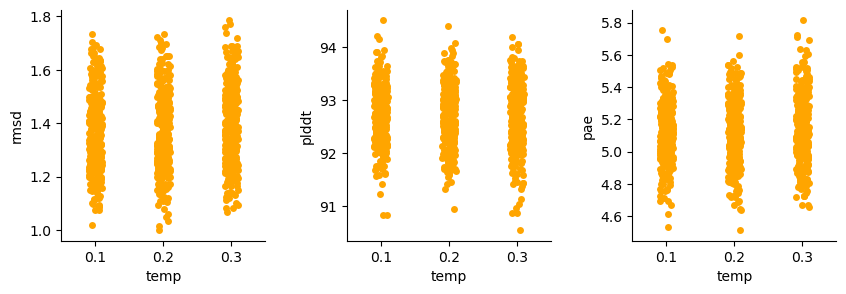

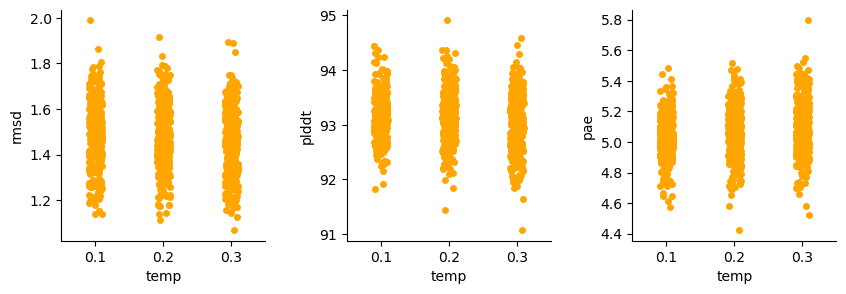

In [10]:
for conv_frac in conservation:
    conv_perc=int(float(conv_frac)*100)
    mpnn_path=f"output/{input}/mpnn_out/mpnn_seqs_conv{conv_perc}.csv"
    af2_path=f"output/{input}/af2/af2_conv{conv_perc}.csv"

    # Open dataframes
    mpnn_scores=pd.read_csv(mpnn_path)
    af2_scores=pd.read_csv(af2_path)
    af2_scores["id"]=af2_scores["model_id"]

    # Merge and save dataframes
    merged_df = pd.merge(af2_scores, mpnn_scores, on='id', how='inner')
    merged_df = merged_df.sort_values("plddt", ascending=False)
    merged_df.to_csv(f"output/{input}/af2_mpnn_{input}_conv{conv_perc}.csv")

    # Plot scores
    create_and_save_plot(merged_df, f"output/{input}/scores_{input}_conv{conv_perc}.png")

In [11]:
filt = merged_df[merged_df["rmsd"]<1.3]
filt

,plddt,pae,rmsd,name,model_id,id,temp,sample,score,global_score,sequence_recovery,seq,original_seq,seq_ident
545,94.912437,4.422492,1.299722,output/full_scgd_tcr/af2/af2_conv70/best_1/ful...,full_scgd_tcr_conv70_262_02,full_scgd_tcr_conv70_262_02,0.2,262,1.0584,1.4548,0.4186,IELVPEHQTVPVTIGVPATLRCSVKGAAIGDYYINWYRKDQGNTMT...,IELVPEHQTVPVSIGVPATLRCSMKGEAIGNYYINWYRKTQGNTMT...,0.827982
473,94.286805,4.658740,1.247385,output/full_scgd_tcr/af2/af2_conv70/best_1/ful...,full_scgd_tcr_conv70_24_03,full_scgd_tcr_conv70_24_03,0.3,24,1.1007,1.4657,0.4264,IELVPEHQTVPVTIGVPATLRCSVKGAAIGDYYINWYRKDQGNTMT...,IELVPEHQTVPVSIGVPATLRCSMKGEAIGNYYINWYRKTQGNTMT...,0.830275
288,94.220529,4.730477,1.177620,output/full_scgd_tcr/af2/af2_conv70/best_1/ful...,full_scgd_tcr_conv70_186_02,full_scgd_tcr_conv70_186_02,0.2,186,1.0373,1.4484,0.3721,IELVPEHQTVPVTIGVPATLRCSVKGAAIGDYYINWYRKDQGNTMT...,IELVPEHQTVPVSIGVPATLRCSMKGEAIGNYYINWYRKTQGNTMT...,0.814220
491,94.071448,4.799004,1.171599,output/full_scgd_tcr/af2/af2_conv70/best_1/ful...,full_scgd_tcr_conv70_246_03,full_scgd_tcr_conv70_246_03,0.3,246,1.1270,1.4729,0.4651,IELVPEHQTVPVTIGVPATLRCSVKGAAIGDYYINWYRKDQGNTMT...,IELVPEHQTVPVSIGVPATLRCSMKGEAIGNYYINWYRKTQGNTMT...,0.841743
73,94.045172,4.783094,1.285797,output/full_scgd_tcr/af2/af2_conv70/best_1/ful...,full_scgd_tcr_conv70_12_03,full_scgd_tcr_conv70_12_03,0.3,12,1.0975,1.4562,0.3798,IELVPEHQTVPVTIGVPATLRCSVKGAAIGDYYINWYRKDQGNTMT...,IELVPEHQTVPVSIGVPATLRCSMKGEAIGNYYINWYRKTQGNTMT...,0.816514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,92.212874,5.438971,1.242728,output/full_scgd_tcr/af2/af2_conv70/best_1/ful...,full_scgd_tcr_conv70_26_02,full_scgd_tcr_conv70_26_02,0.2,26,1.0352,1.4495,0.4031,IELVPEHQTVPVTIGVPATLRCSVKGAAIGDYYINWYRKDQGNTMT...,IELVPEHQTVPVSIGVPATLRCSMKGEAIGNYYINWYRKTQGNTMT...,0.823394
43,92.193816,5.387499,1.231759,output/full_scgd_tcr/af2/af2_conv70/best_1/ful...,full_scgd_tcr_conv70_111_03,full_scgd_tcr_conv70_111_03,0.3,111,1.0992,1.4626,0.4031,IELVPEHQTVPVTIGVPATLRCSVKGAAIGDYYINWYRKTQGNTMT...,IELVPEHQTVPVSIGVPATLRCSMKGEAIGNYYINWYRKTQGNTMT...,0.823394
221,92.072184,5.452367,1.226899,output/full_scgd_tcr/af2/af2_conv70/best_1/ful...,full_scgd_tcr_conv70_165_03,full_scgd_tcr_conv70_165_03,0.3,165,1.1211,1.4695,0.3643,IELVPEHQTVPVTIGVPATLRCSVKGAAIGDYYINWYRKSQGNTMT...,IELVPEHQTVPVSIGVPATLRCSMKGEAIGNYYINWYRKTQGNTMT...,0.811927
743,92.048828,5.395694,1.239203,output/full_scgd_tcr/af2/af2_conv70/best_1/ful...,full_scgd_tcr_conv70_54_03,full_scgd_tcr_conv70_54_03,0.3,54,1.0797,1.4623,0.3566,IELVPEHQTVPVTIGVPATLRCSVKGAAIGDYYINWYRKDQGNTMT...,IELVPEHQTVPVSIGVPATLRCSMKGEAIGNYYINWYRKTQGNTMT...,0.809633
